In [159]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import box

import autoroot
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs
from rs_tools._src.geoprocessing.interp import resample_rioxarray

#### TO DISCUSS:

- When comparing tiles, do we want to project into an arbitrary refernce frame?
    - If yes, what resoltion should we choose?

##### Load xarray datasets

In [153]:
goes_band = 14 # IR 12.3 um
msg_band = 5 # IR 12 um

In [140]:
goes_path = '/mnt/disks/goes-data/goes/'
msg_path = '/mnt/disks/msg-data/msg/'

In [141]:
msg_files = [os.path.join(msg_path, f) for f in os.listdir(msg_path) if f.endswith('.nc')]
msg_files.sort()
goes_files = [os.path.join(goes_path, f) for f in os.listdir(goes_path) if f.endswith('.nc')]
goes_files.sort()

In [142]:
# Pick some example aligned files

msg_files[1], goes_files[0]

('/mnt/disks/msg-data/msg/20200101005743_msg.nc',
 '/mnt/disks/goes-data/goes/20200101010021_goes16.nc')

In [143]:
msg_ds = xr.open_dataset(msg_files[1])
goes_ds = xr.open_dataset(goes_files[0])

#### Reset coordinates to variables and remove latitude/longitude so that the reprojection works.

In [144]:
# Move specific coordinate variables to data variables
goes_ds = goes_ds.reset_coords(["cloud_mask"])
goes_ds = goes_ds.drop_vars(["latitude", "longitude"])

goes_ds = add_goes16_crs(goes_ds)

goes_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

In [145]:
np.unique(goes_ds["cloud_mask"].values)

array([ 0.,  1., nan])

In [146]:
# Move specific coordinate variables to data variables
msg_ds = msg_ds.reset_coords(["cloud_mask"])
msg_ds = msg_ds.drop_vars(["latitude", "longitude"])

msg_ds = add_msg_crs(msg_ds)

msg_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

## Reproject GOES/MSG

#### Add Coordinate Reference Systems

In [12]:
msg_ds = add_msg_crs(msg_ds)
goes_ds = add_goes16_crs(goes_ds)


#### Reproject to an arbitrary coordinate reference frame

In [147]:
from pyproj import CRS

dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.05 # in your destination units, in this case degrees

In [149]:
goes_ds_reproject = goes_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
goes_ds_reproject

<xarray.Dataset> Size: 698MB
Dimensions:                 (x: 3248, y: 2986, band: 16)
Coordinates:
  * x                       (x) float64 26kB -156.3 -156.2 ... 6.037 6.087
  * y                       (y) float64 24kB 74.59 74.54 74.49 ... -74.61 -74.66
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 621MB nan nan nan ... nan nan
    cloud_mask              (y, x) float64 78MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

In [150]:
msg_ds_reproject = msg_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
msg_ds_reproject

<xarray.Dataset> Size: 501MB
Dimensions:             (x: 3252, y: 2965, band: 11)
Coordinates:
  * x                   (x) float64 26kB -81.25 -81.2 -81.15 ... 81.2 81.25 81.3
  * y                   (y) float64 24kB 74.15 74.1 74.05 ... -74.0 -74.05
    msg_seviri_fes_3km  int64 8B 0
  * band                (band) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
Data variables:
    cloud_mask          (y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    Rad                 (band, y, x) float32 424MB nan nan nan ... nan nan nan
Attributes:
    calibration:         radiance
    standard_name:       toa_outgoing_radiance_per_unit_wavenumber
    platform_name:       Meteosat-11
    sensor:              seviri
    units:               mW m-2 sr-1 (cm-1)-1
    orbital_parameters:  {"projection_longitude": 0.0, "projection_latitude":...

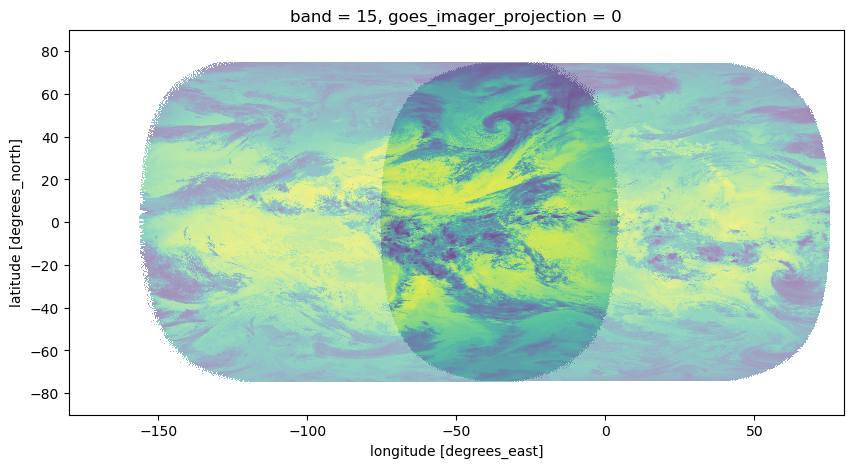

In [155]:
plt.figure(figsize=(10, 5))
msg_ds_reproject.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
goes_ds_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
# suppress color bars
plt.ylim(-90, 90)
plt.xlim(-180, 80);

#### Reproject GOES into MSG reference frame

In [160]:
dst_crs = msg_ds.rio.crs
dst_bounds = msg_ds.rio.bounds
dst_resolution = msg_ds.rio.resolution()[1] # in your destination units, in this case degrees

# extract bounding box
bbox = box(*msg_ds.rio.bounds())

# .clip(geometries=geometries,
geometries = [bbox]

In [162]:
goes_ds_msg = goes_ds.rio.reproject_match(msg_ds)
goes_ds_msg

<xarray.Dataset> Size: 992MB
Dimensions:                 (band: 16, x: 3712, y: 3712)
Coordinates:
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
  * x                       (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * y                       (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
Data variables:
    Rad                     (band, y, x) float32 882MB 0.0 0.0 0.0 ... 0.0 0.0
    cloud_mask              (y, x) float64 110MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

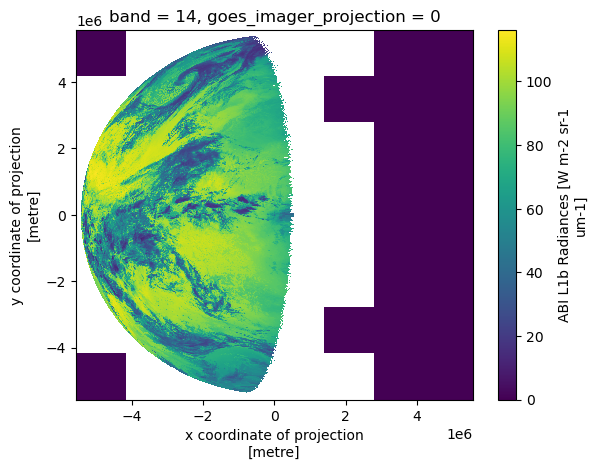

In [163]:
goes_ds_msg.Rad.sel(band=goes_band).plot() # It's not clear why these artifacts are added

#### Clip to common field-of-view

In [164]:
# Extract the bounding boxes of the two datasets
bbox1 = box(*msg_ds.rio.bounds())
bbox2 = box(*goes_ds_msg_2.rio.bounds())

# Find the intersection of the two bounding boxes
intersection_bbox = bbox1.intersection(bbox2)

In [169]:
out = goes_ds_msg.rio.clip_box(*intersection_bbox.bounds, crs=msg_ds.rio.crs)
out

<xarray.Dataset> Size: 992MB
Dimensions:                 (band: 16, x: 3712, y: 3712)
Coordinates:
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
  * x                       (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * y                       (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 882MB 0.0 0.0 0.0 ... 0.0 0.0
    cloud_mask              (y, x) float64 110MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

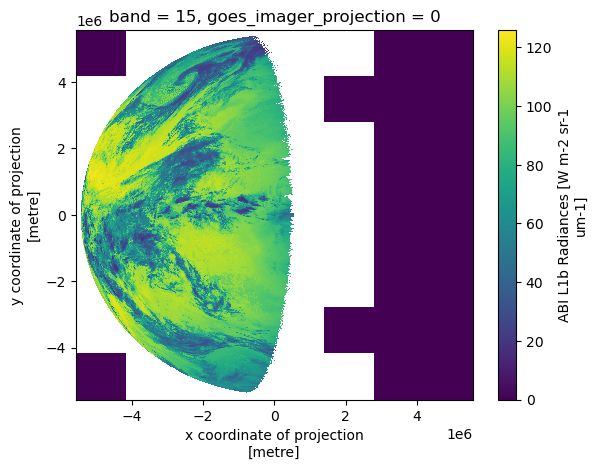

In [166]:
out.Rad.isel(band=goes_band).plot() # Looks the same as before

##### Reproject into EPSG for easier comparison

In [168]:
dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.05 # in your destination units, in this case degrees
out_reproject = out.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
out_reproject

<xarray.Dataset> Size: 694MB
Dimensions:                 (x: 3252, y: 2965, band: 16)
Coordinates:
  * x                       (x) float64 26kB -81.25 -81.2 -81.15 ... 81.25 81.3
  * y                       (y) float64 24kB 74.15 74.1 74.05 ... -74.0 -74.05
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 617MB nan nan nan ... nan nan
    cloud_mask              (y, x) float64 77MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

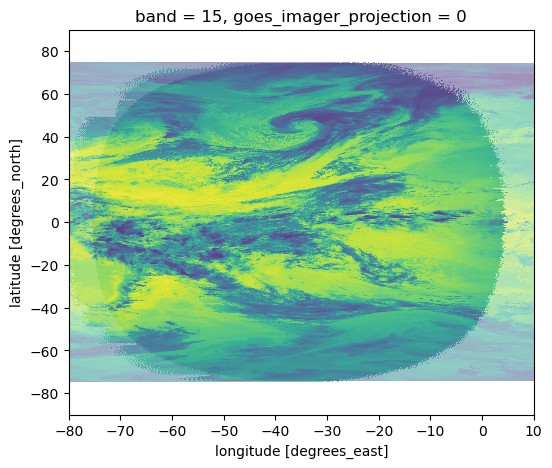

In [171]:
plt.figure(figsize=(6, 5))
msg_ds_reproject.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
goes_ds_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
out_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
plt.xlim(-80, 10)
plt.ylim(-90, 90);

#### Clip to limited field-of-view

In [172]:
bounds = out_reproject.rio.bounds()
bounds_clipped = [-60, -60, -15, 60]

In [173]:
bbox = box(*bounds_clipped)

In [174]:
out_clipped = out_reproject.rio.clip_box(*bbox.bounds)
msg_clipped = msg_ds_reproject.rio.clip_box(*bbox.bounds)

(-60.0, 60.0)

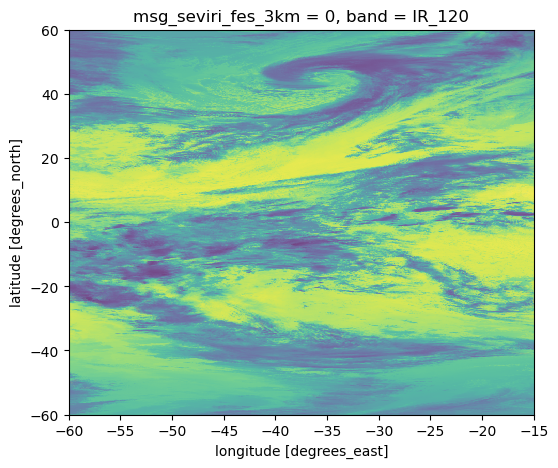

In [176]:
plt.figure(figsize=(6, 5))
out_clipped.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
msg_clipped.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
plt.xlim(-60, -15)
plt.ylim(-60, 60)

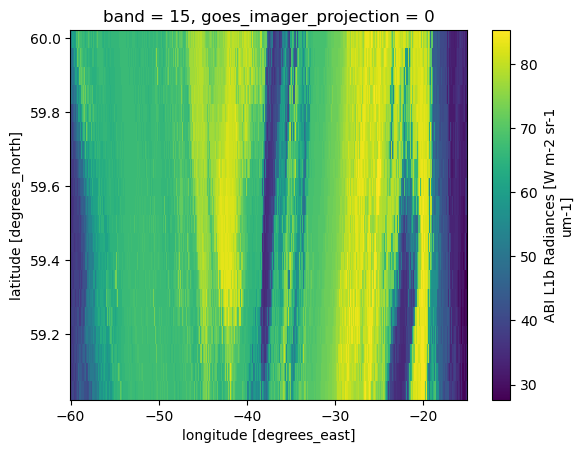

In [128]:
out_clipped.Rad[0:20, 0:20].isel(band=14).plot()

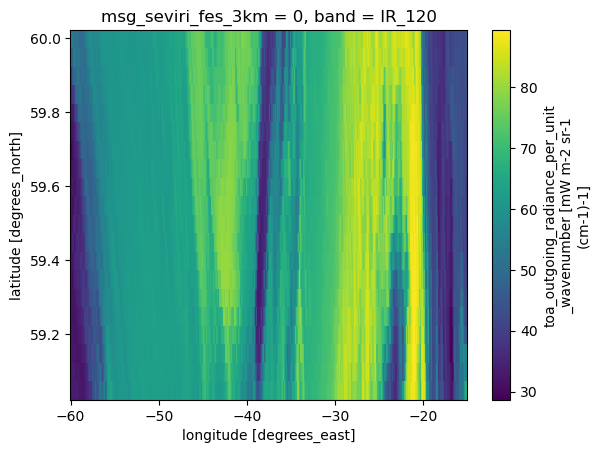

In [126]:
msg_clipped.Rad[0:20, 0:20].isel(band=5).plot()

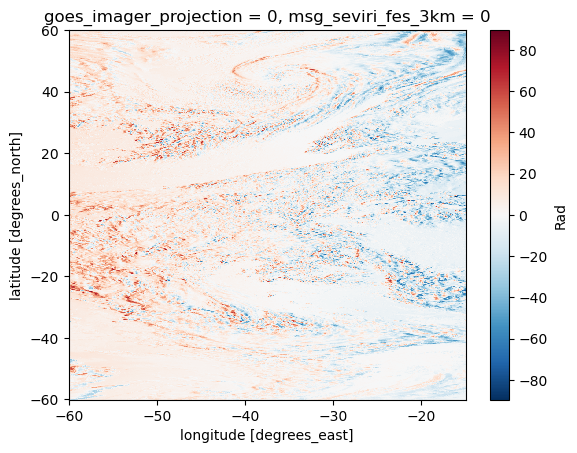

In [177]:
diff = out_clipped.Rad.isel(band=goes_band) - msg_clipped.Rad.isel(band=msg_band)
diff.plot()

In [ ]:
def correct_for_parallax(self):
        """Correct cloudsat lats/lons for parallax when comparing to SEVIRI obs"""

        geo_projection = get_msg_projection()

        # Calculate x/y locations from cloudsat lat/lon
        cs_x, cs_y = geo_projection(
            self.cloudsat_ds.Longitude, self.cloudsat_ds.Latitude
        )

        # Calculate weighted average height of radar reflectivity
        filled_reflectivity = (
            np.clip(self.cloudsat_ds.Radar_Reflectivity, -35, 20).fillna(-35).values
        )
        average_reflectivity_height = np.average(
            self.cloudsat_ds.Height, weights=filled_reflectivity + 35 + 1e-15, axis=1
        )
        average_reflectivity_height[np.all(filled_reflectivity <= -35, axis=1)] = 0

        # Calculate SEVIRI viewing angles at cloudsat locations
        cloudsat_zenith_angle, cloudsat_azimuth_angle = get_satellite_viewing_angles(
            self.cloudsat_ds.Latitude, self.cloudsat_ds.Longitude
        )

        # Calculate parallax distance offset from reflectivity height and zenith angle
        parallax_dist = (
            np.sin(np.radians(cloudsat_zenith_angle)) * average_reflectivity_height
        )

        # Calculate x/y offsets due to parallax
        parallax_x = parallax_dist * np.sin(np.radians(cloudsat_azimuth_angle))
        parallax_y = parallax_dist * np.cos(np.radians(cloudsat_azimuth_angle))

        corrected_lon, corrected_lat = geo_projection(
            cs_x + parallax_x, cs_y + parallax_y, inverse=True
        )

        self.cloudsat_ds.Longitude.data = corrected_lon
        self.cloudsat_ds.Latitude.data = corrected_lat